# Stock analysis

## Import

Libraries

In [1]:
from utils.init import *

from utils.analyse_price import *
from utils.analyse_fundamentals import *
from utils.data import *
from utils.params import *
from utils.pdf import *

In [2]:
TICKER = 'AGL'
COUNTRY = 'AU'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices_dict = {}

## Get data

Run data

Utilities UtilitiesIndependentPowerProducers


,ASX code,Market Cap,weight
1330,ORG,1.777876e+10,0.306358
1130,MEZ,1.381603e+10,0.238073
154,APA,1.003588e+10,0.172935
1117,MCY,8.046978e+09,0.138663
411,CEN,6.011567e+09,0.103589
791,GNE,2.094800e+09,0.036097
1039,LGI,2.486646e+08,0.004285


,ASX code,Market Cap ($bn)
84,AGL,7.95


0.14


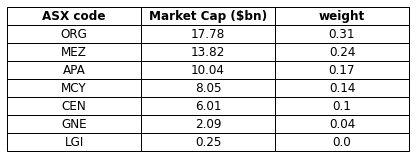

$LGI.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$LGI.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$LGI.AX: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-12-31) (Yahoo error = "Data doesn't exist for startDate = 1609419600, endDate = 1640869200")


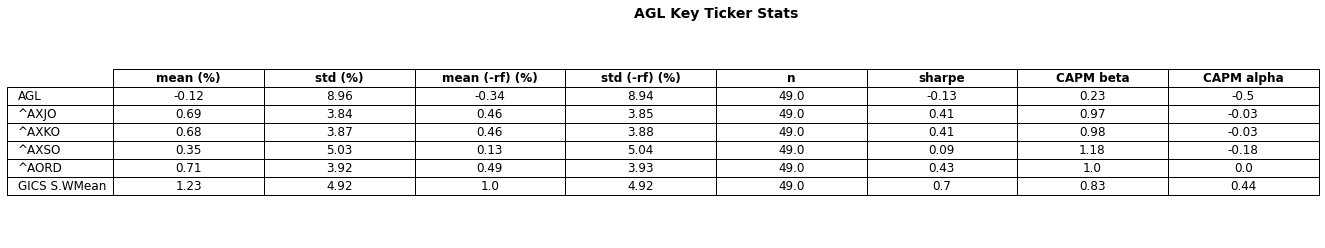

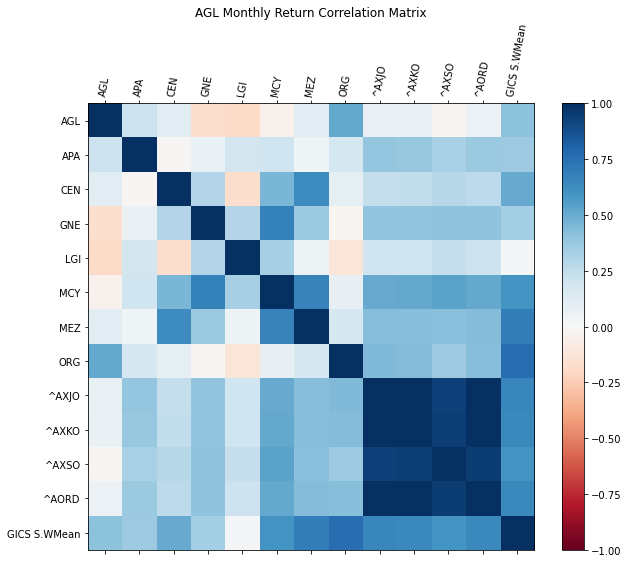

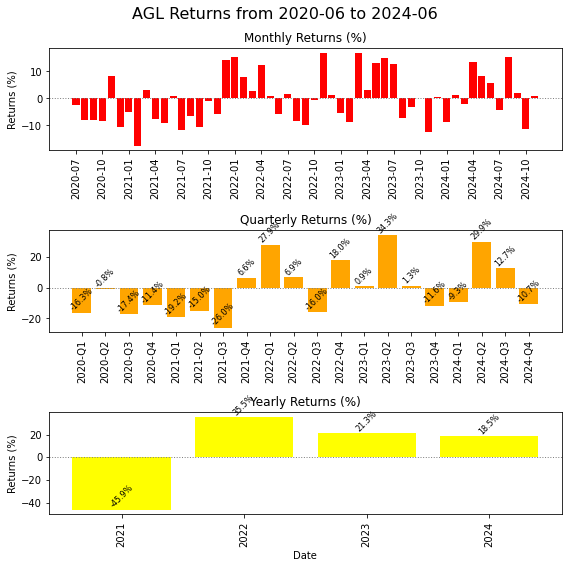

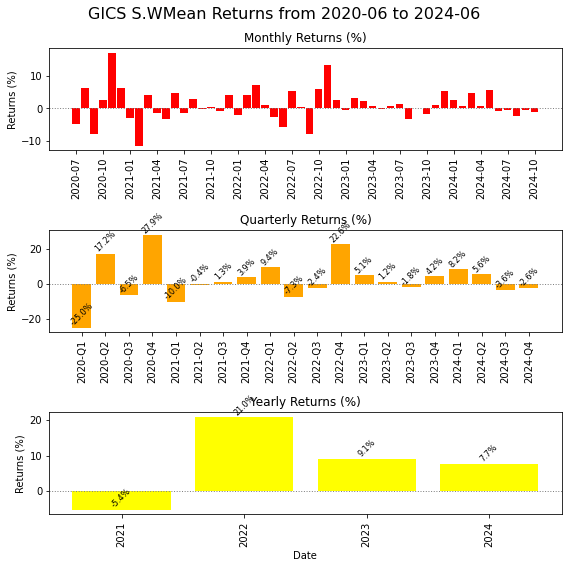

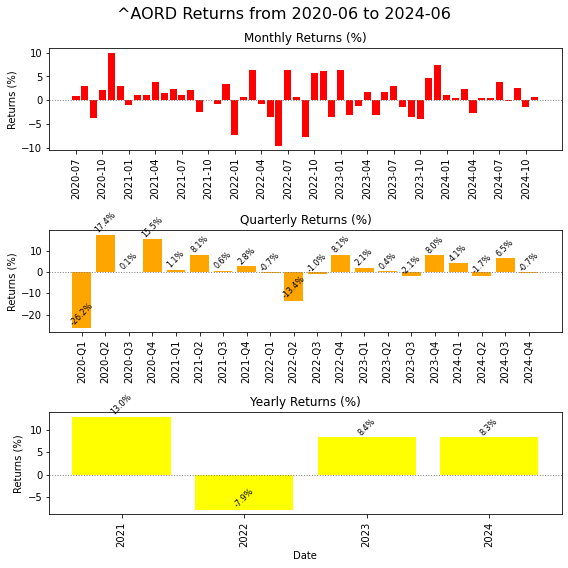

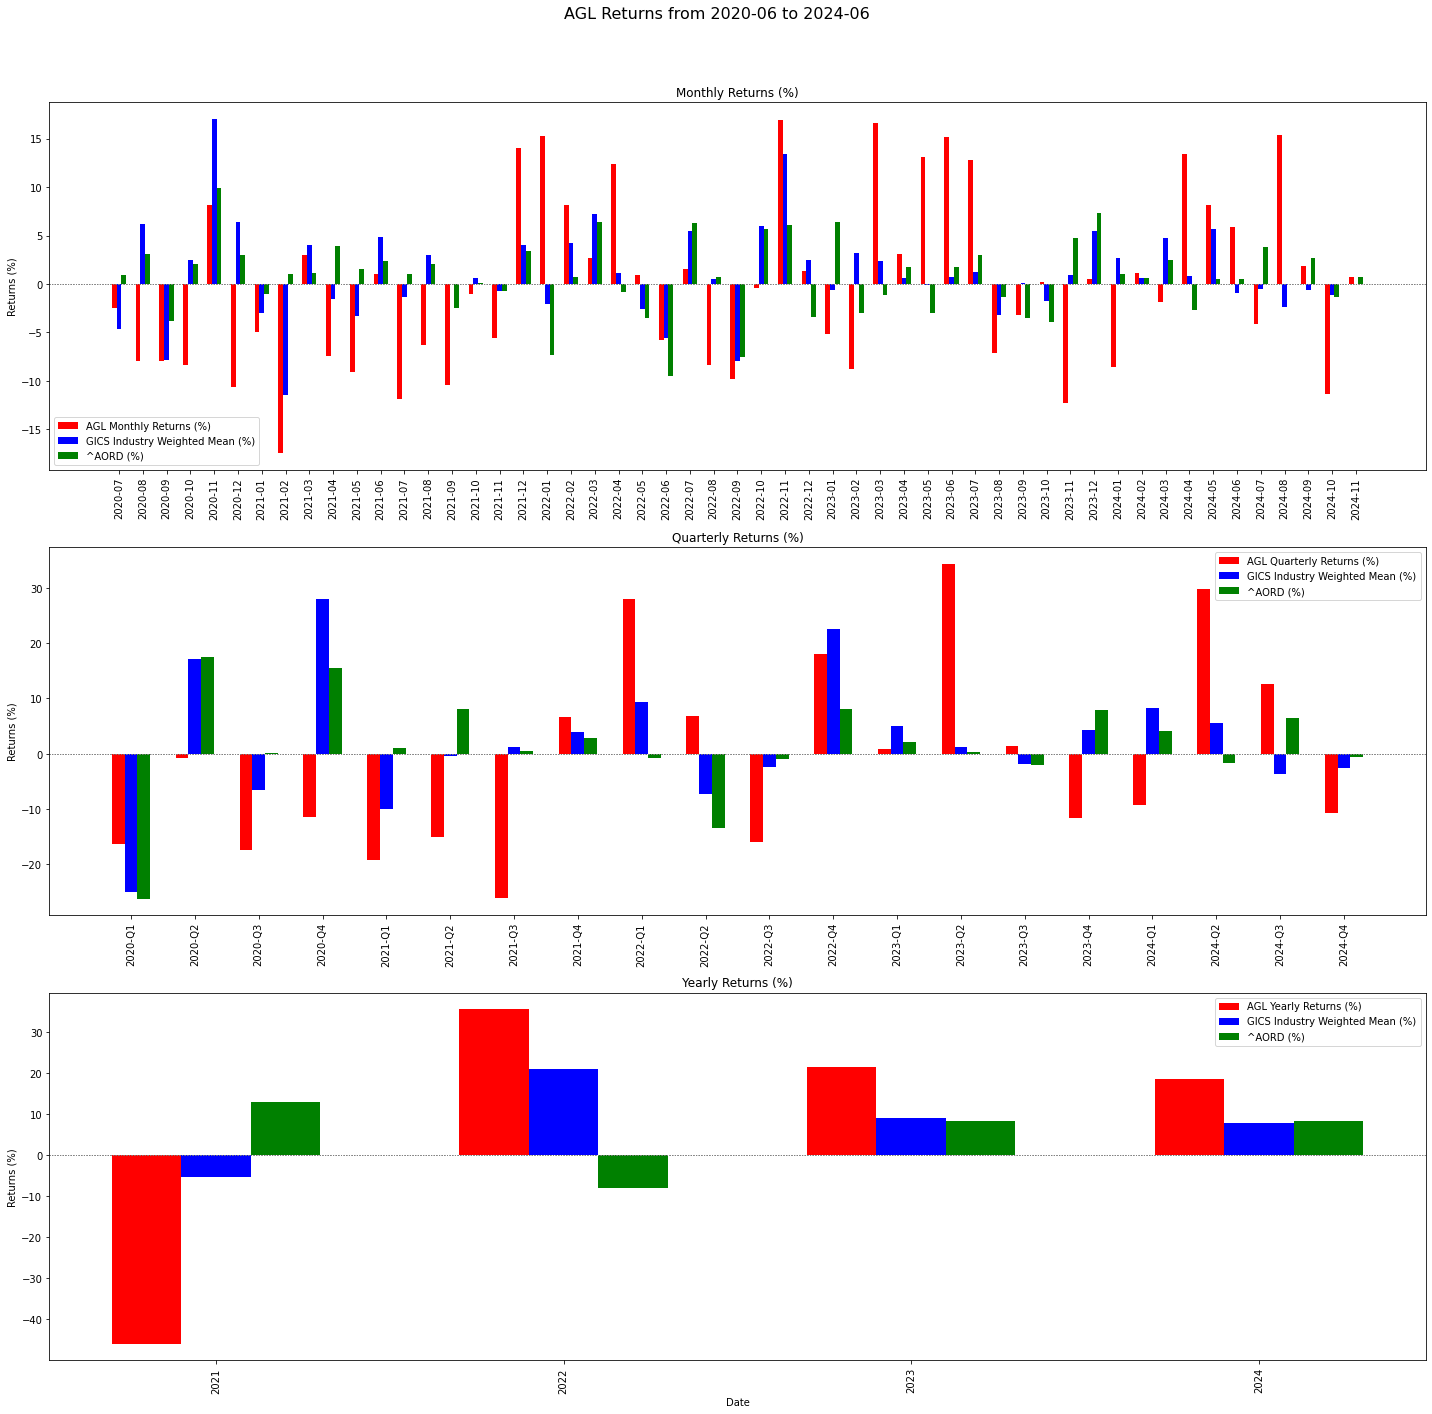

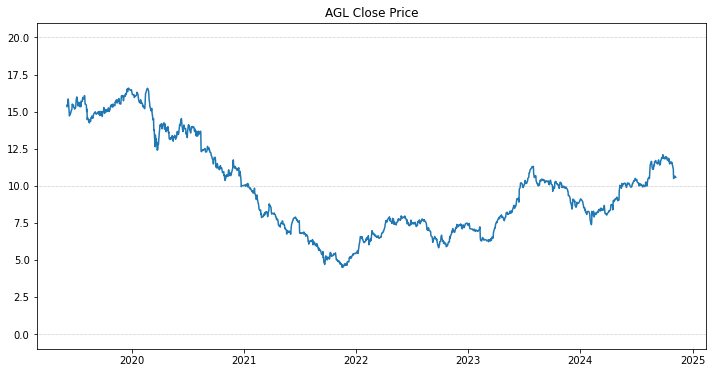

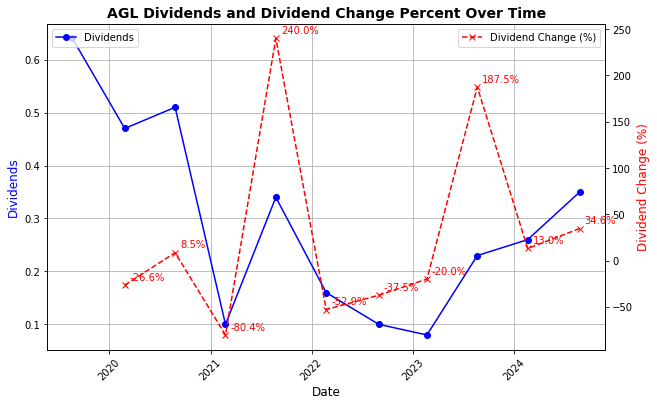

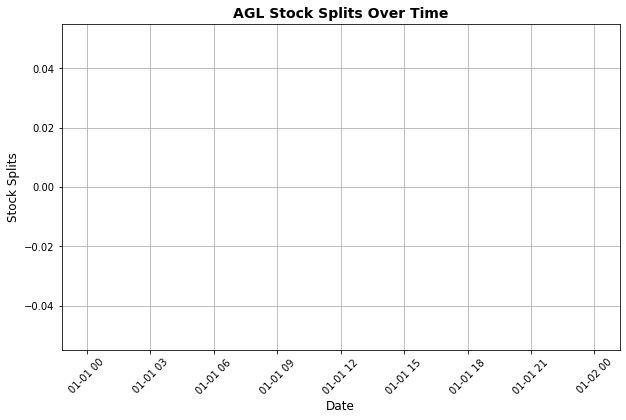

In [3]:
# read in data
index_tickers_list = get_index_tickers_list(COUNTRY)
interest_rate_df_dict = get_interest_rate(COUNTRY)

comparable_tickers = {'type': {}, 'list': []}
if COUNTRY == 'AU':
    asx_companies_directory_df = get_asx_companies_directory()
    asx_gics_df = get_asx_gics()

    # get same gics tickers
    AU_top_list_dict = get_top_ASX_companies_list(asx_companies_directory_df)
    ASX_ticker_gics_dict = get_ASX_ticker_gics(TICKER, asx_gics_df)
    same_gics_ASX_tickers_dict = get_same_gics_ASX_tickers(asx_gics_df,
                                                           ASX_ticker_gics_dict, AU_top_list_dict)
    comparable_ASX_tickers_dict = get_comparable_ASX_tickers(
        TICKER, same_gics_ASX_tickers_dict)

    print(ASX_ticker_gics_dict['Sector'], ASX_ticker_gics_dict['Industry'])

    same_industry_ASX_tickers_mcap_df = get_same_gics_ASX_MCap_weights(TICKER,
                                                                       asx_companies_directory_df, comparable_ASX_tickers_dict)

    # market value and weight
    same_industry_tickers_mcap_df = get_same_industry_tickers_mcap(
        same_industry_ASX_tickers_mcap_df)
    display(same_industry_tickers_mcap_df)

    ticker_mv_df = get_AU_ticker_mv_df(asx_companies_directory_df, TICKER)
    display(ticker_mv_df)

    ticker_proportion_of_market = get_AU_ticker_proportion_of_market(
        ticker_mv_df, same_industry_tickers_mcap_df)
    print(round(ticker_proportion_of_market, 2))

    plot_gics_mcap_weights(TICKER, same_industry_tickers_mcap_df)

    same_gics_industry_weight_dict = get_same_AU_gics_industry_weight_dict(
        same_industry_tickers_mcap_df)

# get historic prices
analysis_needed_ticker_list = get_analysis_needed_ticker_list(
    TICKER, index_tickers_list, comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)
historical_prices_dict = get_historical_prices_for_interested_list(
    analysis_needed_ticker_list, index_tickers_list, historical_prices_dict, COUNTRY)

# get historical returns
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    monthly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['monthly'], 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    quarterly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['quarterly'], 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    yearly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['annualy'], 'Y')

# get GICS industry weighted returns
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if COUNTRY == 'AU' else None,
    index_tickers_list, 'M', comparable_tickers=comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if COUNTRY == 'AU' else None,
    index_tickers_list, 'Q', comparable_tickers=comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if COUNTRY == 'AU' else None,
    index_tickers_list, 'Y', comparable_tickers=comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)

# get stats based on returns
stats_df = get_monthly_stats_for_all_tickers(
    monthly_returns_df_dict, comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers, index_tickers_list, same_industry_ASX_tickers_mcap_df if TICKER == 'AU' else None, TICKER, first_end_of_quarter, last_end_of_quarter, COUNTRY)
plot_key_ticker_stats_table(
    stats_df, TICKER, comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers, index_tickers_list)

# correlation chart
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)
plot_correlation(correlation_df, ticker=TICKER)

# plot returns
# interested ticker
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

if COUNTRY == 'AU' and len(comparable_ASX_tickers_dict['list']) > 0:
    plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                    'quarterly_returns_df_dict': quarterly_returns_df_dict,
                    'yearly_returns_df_dict': yearly_returns_df_dict,
                    'ticker': 'GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else 'GICS S.WMean',
                    'first_end_of_quarter': first_end_of_quarter,
                    'last_end_of_quarter': last_end_of_quarter,
                    'underlying_ticker': TICKER})

plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD' if COUNTRY == 'AU' else '^GSPC',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers, 'country': COUNTRY}
                         )

# price movement
plot_close_price_with_dollar_lines(TICKER, historical_prices_dict)

# dividends
historical_dividends = get_historical_dividends(
    TICKER, historical_prices_dict, COUNTRY)
plot_dividends(TICKER, historical_dividends, historical_prices_dict, COUNTRY)

# historical splits
historical_splits = get_historical_splits(
    TICKER, historical_prices_dict, COUNTRY)
plot_splits_over_time(TICKER, historical_prices_dict, COUNTRY)

# Fundamentals

In [4]:
raw_fundamentals_stats_dict['APA']

NameError: name 'raw_fundamentals_stats_dict' is not defined

Missing data for Net Profit for ticker AGL: 'Tax Provision'
Missing data for Total Asset for ticker AGL: 'Total Non Current Liabilities Net Minority Interest'


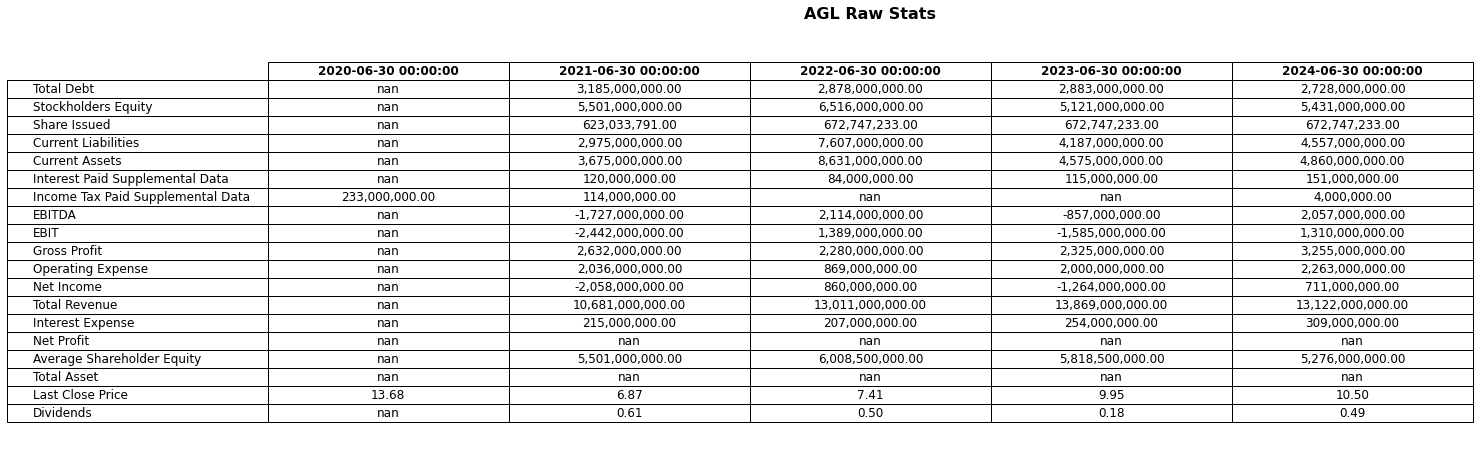

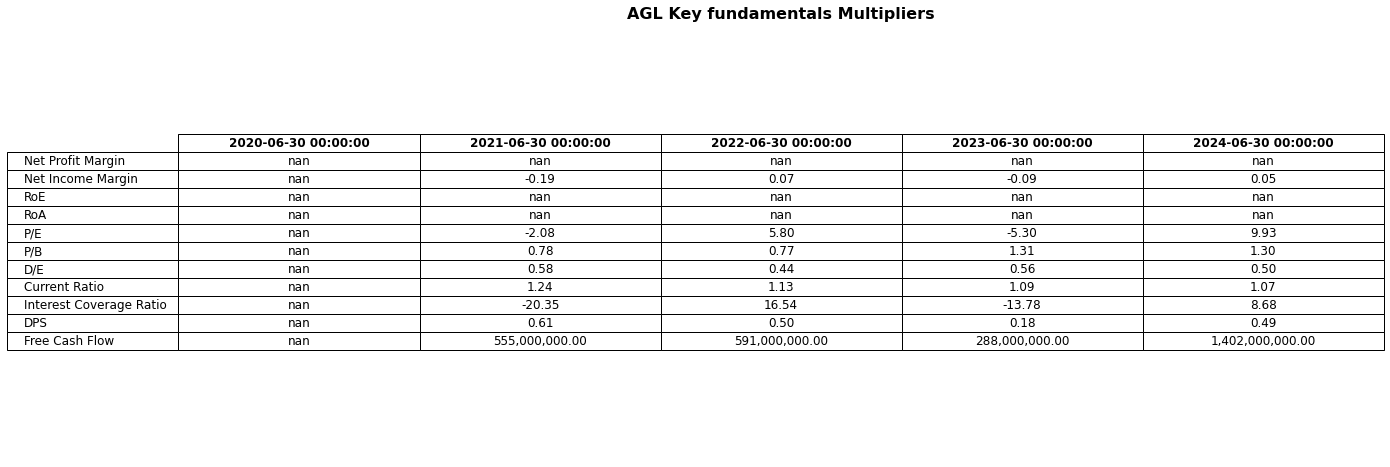

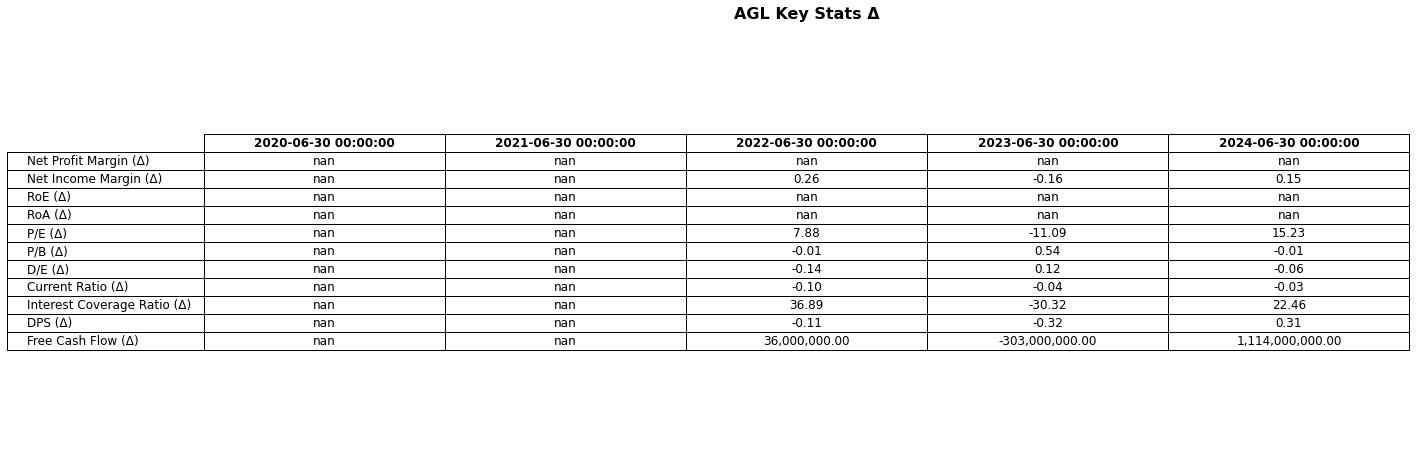


 APA
Missing data for Net Profit for ticker APA: 'Tax Provision'
Missing data for Total Asset for ticker APA: 'Total Non Current Liabilities Net Minority Interest'

 CEN
Missing data for Net Profit for ticker CEN: 'Tax Provision'
Missing data for Total Asset for ticker CEN: 'Total Non Current Liabilities Net Minority Interest'

 GNE
Interest Paid Supplemental Data not found for ticker GNE: 'Interest Paid Supplemental Data'
Missing data for Net Profit for ticker GNE: 'Tax Provision'
Missing data for Total Asset for ticker GNE: 'Total Non Current Liabilities Net Minority Interest'
Missing data for Interest Coverage Ratio for ticker GNE: 'Interest Paid Supplemental Data'

 LGI
Missing data for Net Profit for ticker LGI: 'Tax Provision'
Missing data for Total Asset for ticker LGI: 'Total Non Current Liabilities Net Minority Interest'

 MCY
Missing data for Net Profit for ticker MCY: 'Tax Provision'
Missing data for Total Asset for ticker MCY: 'Total Non Current Liabilities Net Minority In

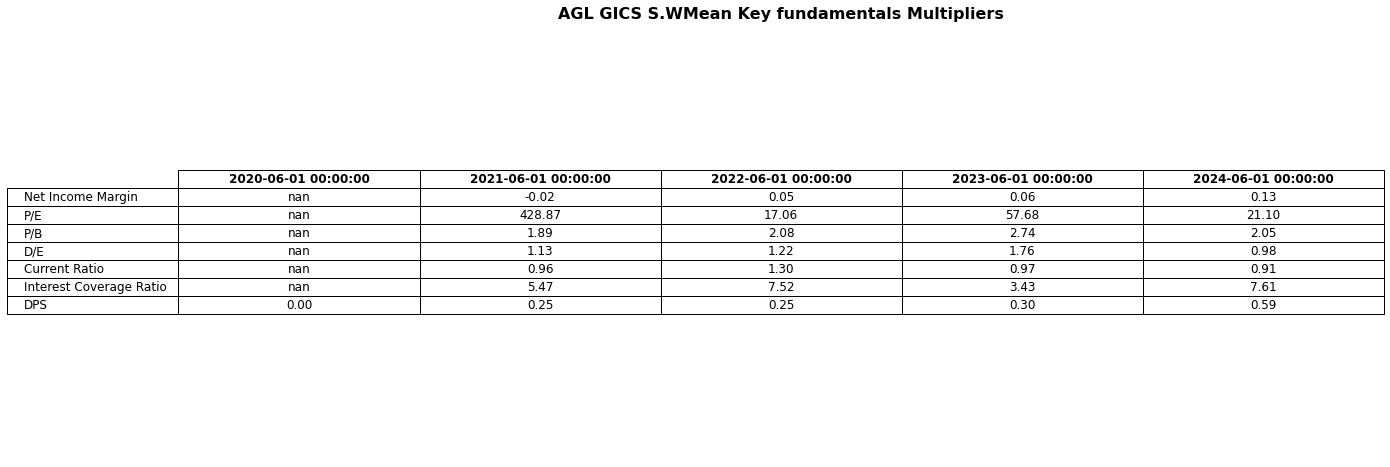

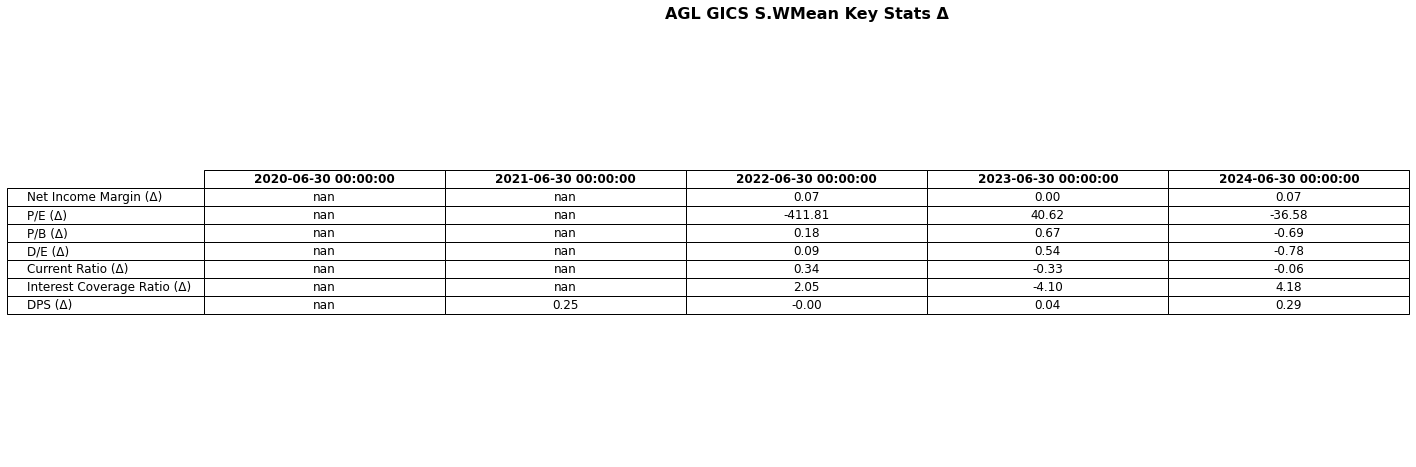

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Column Net Profit Margin not found for GICS: 'Net Profit Margin'


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


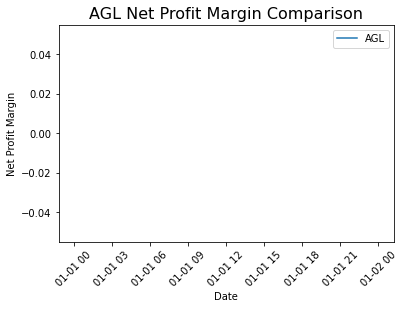

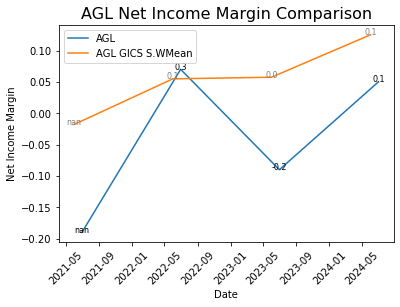

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Column RoE not found for GICS: 'RoE'


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


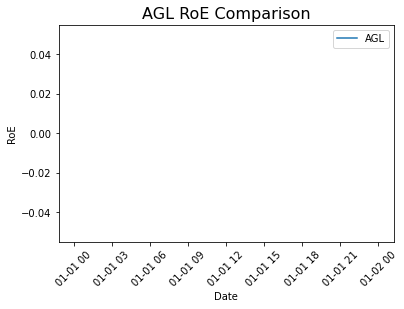

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Column RoA not found for GICS: 'RoA'


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


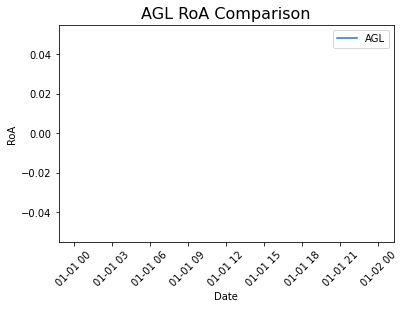

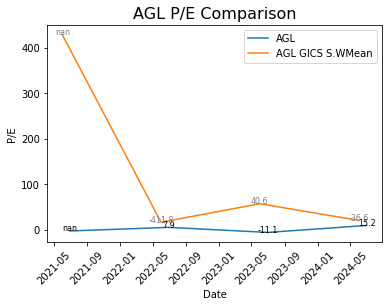

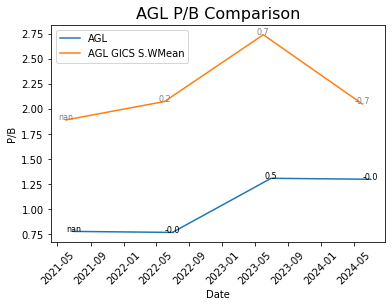

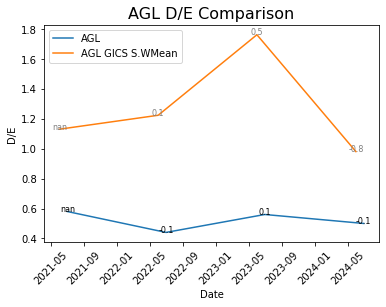

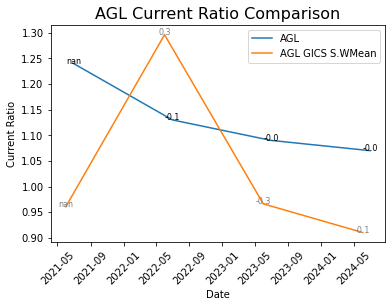

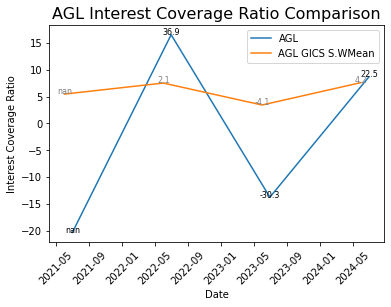

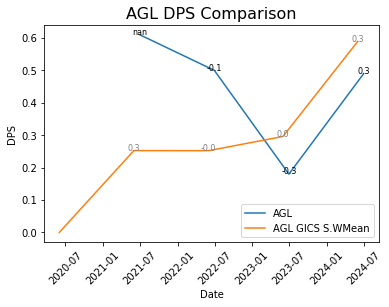

Column Free Cash Flow not found for GICS: 'Free Cash Flow'


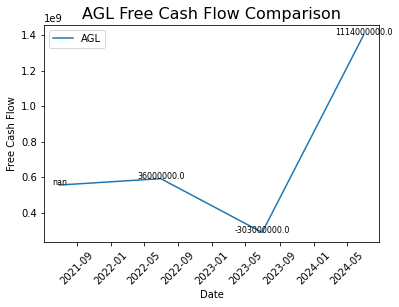

In [5]:
got_fundamentals = False

if not (COUNTRY == 'AU' and ASX_ticker_gics_dict['Sector'] == 'Unknown' and ASX_ticker_gics_dict['Industry'] == 'Unknown'):

    got_fundamentals = True

    # get fundamentals for ticker of interest
    interested_ticker_raw_fundamentals_stats, \
        interested_ticker_key_interested_fundamentals_stats, \
            interested_ticker_key_interested_fundamentals_stats_diff, \
                object = get_fundamentals_dfs(
                        first_end_of_quarter, historical_prices_dict, \
                            TICKER, COUNTRY)
    # create tables for fundamentals for ticker of interest
    plot_raw_fundamentals_stats_table(
        interested_ticker_raw_fundamentals_stats, TICKER)
    plot_key_fundamentals_multipliers_table(
        interested_ticker_key_interested_fundamentals_stats, TICKER)
    plot_key_fundamentals_multipliers_diff_table(
        interested_ticker_key_interested_fundamentals_stats_diff, TICKER)

    # get fundamentals for comparable tickers
    if COUNTRY == 'AU':

        # get raw fundamentals stats for comparable tickers
        raw_fundamentals_stats_dict, object_dict = get_raw_fundamentals_stats(
            comparable_ASX_tickers_dict, first_end_of_quarter, historical_prices_dict, COUNTRY)

        # aggregate and integrate the fundamentals stats for comparable tickers
        agg_interpolated_fundamentals_stats_df_dict = get_agg_interpolated_fundamentals_stats(
            raw_fundamentals_stats_dict, interested_ticker_key_interested_fundamentals_stats_diff)

        # get key interested fundamental stats from the interpolated fundamentals for comparable tickers
        key_interested_fundamentals_stats_dict, key_interested_fundamentals_stats_diff_dict = get_key_interested_fundamentals_stats_for_comparable(
            agg_interpolated_fundamentals_stats_df_dict, object_dict, first_end_of_quarter, historical_prices_dict)

        # get weighted average of the key interested fundamentals stats for the GICS industry
        weighted_GICS_key_interested_fundamentals_stats = get_weighted_fundamentals(
            key_interested_fundamentals_stats_dict, same_gics_industry_weight_dict)
        weighted_GICS_key_interested_fundamentals_stats.index = weighted_GICS_key_interested_fundamentals_stats.index

        plot_key_fundamentals_multipliers_table(
            weighted_GICS_key_interested_fundamentals_stats.astype(float).round(2),  f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')

        # get percentage change for key interested fundamental stats for the weighted average of the GICS industry
        weighted_GICS_key_interested_fundamentals_stats_diff = get_key_interested_fundamentals_stat_diff(
            weighted_GICS_key_interested_fundamentals_stats)
        weighted_GICS_key_interested_fundamentals_stats_diff.index = interested_ticker_key_interested_fundamentals_stats_diff.index

        plot_key_fundamentals_multipliers_diff_table(
            weighted_GICS_key_interested_fundamentals_stats_diff, f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')

    else:
        weighted_GICS_key_interested_fundamentals_stats = pd.DataFrame()

    # plot the comparison of key interested fundamentals for the ticker of interest and the weighted average of the GICS industry
    plot_key_fundamentals_multipliers(
        interested_ticker_key_interested_fundamentals_stats, weighted_GICS_key_interested_fundamentals_stats, TICKER, {})

PDF

In [5]:
create_pdf(**{
    'ASX_ticker_gics_dict': ASX_ticker_gics_dict,
    'comparable_ASX_tickers_dict': comparable_ASX_tickers_dict,
    'ticker_mv_df': ticker_mv_df,
    'same_industry_tickers_mcap_df': same_industry_tickers_mcap_df,
    'got_fundamentals': got_fundamentals,
    'TICKER': TICKER,
    'COUNTRY': COUNTRY,
})